In [1]:
import logging

logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)

In [2]:
import data
from sklearn.preprocessing import StandardScaler
from torch.nn import MSELoss
from torch.utils.data import DataLoader
from IPython.core.debugger import set_trace
import importlib
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(42)
torch.set_num_threads(1)

In [3]:
importlib.reload(data)

response_data = data.ExVivoDrugData.load_data()
merge_data = data.MergeData.load_data()

2019-11-30 09:18:30 INFO     Loading drug response data
2019-11-30 09:18:33 INFO     Drug response data loaded
2019-11-30 09:18:33 INFO     Loading merge data
2019-11-30 09:18:34 INFO     Merge data loaded


In [4]:
overlapping_genes = list(set(response_data.X.columns).intersection(merge_data.data.columns))
merge_data.data = merge_data.data[overlapping_genes]
response_data.X = response_data.X[["patient_id"] + response_data.drug_columns + overlapping_genes]

In [5]:
kfold_split = response_data.kfold_patient_split(5)

2019-11-30 09:18:35 INFO     Splitting drug response data into 5 folds
2019-11-30 09:18:41 INFO     Splitting complete


In [6]:
max_patients = 0
drug_with_max_patients = None

for drug_col in response_data.drug_columns:
    genotypes_for_drug = response_data.X[response_data.X[drug_col] == 1]
    genotypes_for_drug = genotypes_for_drug.groupby("patient_id").mean()
    patients_for_drug = genotypes_for_drug.shape[0]
    if patients_for_drug > max_patients:
        max_patients = patients_for_drug
        drug_with_max_patients = drug_col

In [7]:
learning_rate = 5e-7
prior_learning_rate = 5e-7
patience=50

In [8]:
import datetime
import time
from utils import EarlyStopping

criterion = MSELoss()

def train(model):
    
    print("Beginning model training at {}".format(datetime.datetime.now()))
    early_stopping = EarlyStopping(patience=patience)
    test_losses = []
    epoch = 0
    while True:
        start_time = time.time()
        model.train()
        for X_batch, y_batch in train_loader:
            f1_optimizer.zero_grad()
            X_batch = X_batch.float().cuda()
            y_batch = y_batch.float().cuda()
            
            output = model(X_batch)
            loss_train = criterion(output, y_batch)
            
            loss_train.backward()
            f1_optimizer.step()
            
        model.eval()
        for X_batch, y_batch in valid_loader:
            X_batch = X_batch.float().cuda()
            y_batch = y_batch.float().cuda()

            output = model(X_batch)
            loss_valid = criterion(output, y_batch).item()
            end_time = time.time()
            epoch_time = end_time - start_time
        
        if epoch % 10 == 0:
            logging.info("Epoch {} completed in {} secs with valid loss {:.4f}".format(epoch, epoch_time, loss_valid))
            
        early_stopping(loss_valid, model)

        if early_stopping.early_stop:
            print("Early stopping on epoch {}".format(epoch))
            break
        epoch += 1
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.float().cuda()
        y_batch = y_batch.float().cuda()

        output = model(X_batch)
        loss_test = criterion(output, y_batch).item()
    return loss_test

In [9]:
from models import MLP
import torch
from torch import optim

data_loaders = []

for split in kfold_split:

    max_drug_indices_train = split.X_train[drug_with_max_patients] == 1
    max_drug_indices_valid = split.X_valid[drug_with_max_patients] == 1
    max_drug_indices_test = split.X_test[drug_with_max_patients] == 1

    split.X_train = split.X_train[max_drug_indices_train].groupby("patient_id").mean()
    split.X_test = split.X_test[max_drug_indices_test].groupby("patient_id").mean()
    split.X_valid = split.X_valid[max_drug_indices_valid].groupby("patient_id").mean()
    split.y_train = split.y_train[max_drug_indices_train].groupby("patient_id").mean()
    split.y_test = split.y_test[max_drug_indices_test].groupby("patient_id").mean()
    split.y_valid = split.y_valid[max_drug_indices_valid].groupby("patient_id").mean()

    split.X_train.drop(response_data.drug_columns, axis=1, inplace=True)
    split.X_test.drop(response_data.drug_columns, axis=1, inplace=True)
    split.X_valid.drop(response_data.drug_columns, axis=1, inplace=True)
    
    X_train = split.X_train
    y_train = split.y_train

    X_test = split.X_test
    y_test = split.y_test
    
    X_valid = split.X_valid
    y_valid = split.y_valid
    
    feature_scaler = StandardScaler()
    outcome_scaler = StandardScaler()

    logging.info("Fitting feature scalers")
    feature_scaler.fit(X_train[X_train.columns])
    outcome_scaler.fit(y_train[y_train.columns])
    logging.info("Finished fitting feature scalers")

    logging.info("Applying feature scalar")
    X_train[X_train.columns] = feature_scaler.transform(X_train[X_train.columns])
    X_test[X_test.columns] = feature_scaler.transform(X_test[X_test.columns])
    X_valid[X_valid.columns] = feature_scaler.transform(X_valid[X_valid.columns])

    y_train[y_train.columns] = outcome_scaler.transform(y_train[y_train.columns])
    y_test[y_test.columns] = outcome_scaler.transform(y_test[y_test.columns])
    y_valid[y_valid.columns] = outcome_scaler.transform(y_valid[y_valid.columns])
    logging.info("Finished scaling features")
    
    # Create random Tensors to hold inputs and outputs
    train_dataset = data.ExVivoDrugData(X_train, y_train)
    test_dataset = data.ExVivoDrugData(X_test, y_test)
    valid_dataset = data.ExVivoDrugData(X_valid, y_valid)

    batch_size=32
    
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=X_test.shape[0],
        shuffle=False,
        drop_last=False
    )
    
    valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=X_valid.shape[0],
        shuffle=False,
        drop_last=False
    )
    
    data_loaders.append((train_loader, test_loader, valid_loader))

2019-11-30 09:18:54 INFO     Fitting feature scalers
2019-11-30 09:18:54 INFO     Finished fitting feature scalers
2019-11-30 09:18:54 INFO     Applying feature scalar
2019-11-30 09:18:54 INFO     Finished scaling features
2019-11-30 09:18:54 INFO     Fitting feature scalers
2019-11-30 09:18:54 INFO     Finished fitting feature scalers
2019-11-30 09:18:54 INFO     Applying feature scalar
2019-11-30 09:18:54 INFO     Finished scaling features
2019-11-30 09:18:55 INFO     Fitting feature scalers
2019-11-30 09:18:55 INFO     Finished fitting feature scalers
2019-11-30 09:18:55 INFO     Applying feature scalar
2019-11-30 09:18:55 INFO     Finished scaling features
2019-11-30 09:18:55 INFO     Fitting feature scalers
2019-11-30 09:18:55 INFO     Finished fitting feature scalers
2019-11-30 09:18:55 INFO     Applying feature scalar
2019-11-30 09:18:55 INFO     Finished scaling features
2019-11-30 09:18:55 INFO     Fitting feature scalers
2019-11-30 09:18:55 INFO     Finished fitting feature s

In [10]:
test_errors_no_prior = []

for train_loader, test_loader, valid_loader in data_loaders:
    D_in, H1, H2, D_out = train_loader.dataset.X.shape[1], 512, 256, 1
    f1 = MLP(D_in=D_in, H1=H1, H2=H2, D_out=D_out, dropout=0.2).cuda().float()
    f1_optimizer = optim.Adam(f1.parameters(), lr=learning_rate, weight_decay=5e-3)
    
    test_errors_no_prior.append(train(f1))

2019-11-30 09:18:59 INFO     Epoch 0 completed in 0.11751818656921387 secs with valid loss 0.9824


Beginning model training at 2019-11-30 09:18:59.685576


2019-11-30 09:19:03 INFO     Epoch 10 completed in 0.10628485679626465 secs with valid loss 0.9513
2019-11-30 09:19:07 INFO     Epoch 20 completed in 0.10671710968017578 secs with valid loss 0.9292
2019-11-30 09:19:11 INFO     Epoch 30 completed in 0.1031792163848877 secs with valid loss 0.9122
2019-11-30 09:19:15 INFO     Epoch 40 completed in 0.10393047332763672 secs with valid loss 0.8941
2019-11-30 09:19:19 INFO     Epoch 50 completed in 0.10081863403320312 secs with valid loss 0.8735
2019-11-30 09:19:23 INFO     Epoch 60 completed in 0.10790252685546875 secs with valid loss 0.8570
2019-11-30 09:19:26 INFO     Epoch 70 completed in 0.10111069679260254 secs with valid loss 0.8391
2019-11-30 09:19:30 INFO     Epoch 80 completed in 0.10081005096435547 secs with valid loss 0.8221
2019-11-30 09:19:34 INFO     Epoch 90 completed in 0.10437417030334473 secs with valid loss 0.8047
2019-11-30 09:19:38 INFO     Epoch 100 completed in 0.0968177318572998 secs with valid loss 0.7896
2019-11-30 

Early stopping on epoch 796
Beginning model training at 2019-11-30 09:22:44.242245


2019-11-30 09:22:48 INFO     Epoch 10 completed in 0.10782027244567871 secs with valid loss 0.8280
2019-11-30 09:22:51 INFO     Epoch 20 completed in 0.1026618480682373 secs with valid loss 0.7888
2019-11-30 09:22:55 INFO     Epoch 30 completed in 0.10096883773803711 secs with valid loss 0.7592
2019-11-30 09:22:59 INFO     Epoch 40 completed in 0.10287976264953613 secs with valid loss 0.7358
2019-11-30 09:23:03 INFO     Epoch 50 completed in 0.11085319519042969 secs with valid loss 0.7156
2019-11-30 09:23:07 INFO     Epoch 60 completed in 0.10474109649658203 secs with valid loss 0.6994
2019-11-30 09:23:11 INFO     Epoch 70 completed in 0.10201215744018555 secs with valid loss 0.6838
2019-11-30 09:23:15 INFO     Epoch 80 completed in 0.10734987258911133 secs with valid loss 0.6703
2019-11-30 09:23:19 INFO     Epoch 90 completed in 0.10388040542602539 secs with valid loss 0.6569
2019-11-30 09:23:22 INFO     Epoch 100 completed in 0.10261011123657227 secs with valid loss 0.6459
2019-11-30

Early stopping on epoch 880
Beginning model training at 2019-11-30 09:27:09.397340


2019-11-30 09:27:13 INFO     Epoch 10 completed in 0.10502815246582031 secs with valid loss 1.1027
2019-11-30 09:27:17 INFO     Epoch 20 completed in 0.10199999809265137 secs with valid loss 1.0754
2019-11-30 09:27:20 INFO     Epoch 30 completed in 0.10383033752441406 secs with valid loss 1.0571
2019-11-30 09:27:24 INFO     Epoch 40 completed in 0.10322093963623047 secs with valid loss 1.0413
2019-11-30 09:27:28 INFO     Epoch 50 completed in 0.10957121849060059 secs with valid loss 1.0300
2019-11-30 09:27:32 INFO     Epoch 60 completed in 0.10323405265808105 secs with valid loss 1.0197
2019-11-30 09:27:36 INFO     Epoch 70 completed in 0.10129427909851074 secs with valid loss 1.0104
2019-11-30 09:27:41 INFO     Epoch 80 completed in 0.10217094421386719 secs with valid loss 1.0013
2019-11-30 09:27:44 INFO     Epoch 90 completed in 0.10322213172912598 secs with valid loss 0.9938
2019-11-30 09:27:48 INFO     Epoch 100 completed in 0.10296392440795898 secs with valid loss 0.9849
2019-11-3

Early stopping on epoch 690
Beginning model training at 2019-11-30 09:30:29.866394


2019-11-30 09:30:33 INFO     Epoch 10 completed in 0.09949755668640137 secs with valid loss 0.8099
2019-11-30 09:30:37 INFO     Epoch 20 completed in 0.1012263298034668 secs with valid loss 0.7888
2019-11-30 09:30:41 INFO     Epoch 30 completed in 0.10395669937133789 secs with valid loss 0.7790
2019-11-30 09:30:45 INFO     Epoch 40 completed in 0.10873866081237793 secs with valid loss 0.7735
2019-11-30 09:30:49 INFO     Epoch 50 completed in 0.10903596878051758 secs with valid loss 0.7706
2019-11-30 09:30:51 INFO     Epoch 60 completed in 0.10637378692626953 secs with valid loss 0.7690
2019-11-30 09:30:53 INFO     Epoch 70 completed in 0.0947723388671875 secs with valid loss 0.7685
2019-11-30 09:30:54 INFO     Epoch 80 completed in 0.09334754943847656 secs with valid loss 0.7695
2019-11-30 09:30:55 INFO     Epoch 90 completed in 0.09505391120910645 secs with valid loss 0.7703
2019-11-30 09:30:56 INFO     Epoch 100 completed in 0.09303450584411621 secs with valid loss 0.7697
2019-11-30 

Early stopping on epoch 114
Beginning model training at 2019-11-30 09:30:57.711628


2019-11-30 09:31:01 INFO     Epoch 10 completed in 0.10027217864990234 secs with valid loss 0.9821
2019-11-30 09:31:05 INFO     Epoch 20 completed in 0.10177779197692871 secs with valid loss 0.9074
2019-11-30 09:31:09 INFO     Epoch 30 completed in 0.10612201690673828 secs with valid loss 0.8536
2019-11-30 09:31:13 INFO     Epoch 40 completed in 0.09541010856628418 secs with valid loss 0.8094
2019-11-30 09:31:16 INFO     Epoch 50 completed in 0.10655450820922852 secs with valid loss 0.7742
2019-11-30 09:31:20 INFO     Epoch 60 completed in 0.10741567611694336 secs with valid loss 0.7419
2019-11-30 09:31:24 INFO     Epoch 70 completed in 0.12435054779052734 secs with valid loss 0.7184
2019-11-30 09:31:28 INFO     Epoch 80 completed in 0.09729981422424316 secs with valid loss 0.6988
2019-11-30 09:31:32 INFO     Epoch 90 completed in 0.10138225555419922 secs with valid loss 0.6835
2019-11-30 09:31:36 INFO     Epoch 100 completed in 0.10273027420043945 secs with valid loss 0.6693
2019-11-3

Early stopping on epoch 376


In [11]:
import egexplainer
import importlib

importlib.reload(egexplainer)

APExp = egexplainer.VariableBatchExplainer(train_dataset)

In [12]:
from models import LinearModel

prior_info = merge_data.data.T
prior_info = torch.FloatTensor(prior_info.values).cuda()
prior_mlp_errors = []

def train_with_learned_prior(f1, f2):
    
    print("Beginning model training at {}".format(datetime.datetime.now()))
    early_stopping = EarlyStopping(patience=patience)
    test_losses = []
    epoch = 0
    while True:
        start_time = time.time()
        f1.train()
        for X_batch, y_batch in train_loader:
            f1_optimizer.zero_grad()
            f2_optimizer.zero_grad()
            
            X_batch = X_batch.float().cuda()
            y_batch = y_batch.float().cuda()
            
            output = f1(X_batch)
            
            eg = APExp.shap_values(f1, X_batch)
            prior_differences = f2(prior_info).squeeze()
            prior_loss = (prior_differences - eg).abs().mean()
            
            loss_train = criterion(output, y_batch) + prior_loss
            
            loss_train.backward()
            f1_optimizer.step()
            f2_optimizer.step()
            
        f1.eval()
        for X_batch, y_batch in valid_loader:
            X_batch = X_batch.float().cuda()
            y_batch = y_batch.float().cuda()

            output = f1(X_batch)
            loss_valid = criterion(output, y_batch).item()
            end_time = time.time()
            epoch_time = end_time - start_time
        
        if epoch % 10 == 0:
            logging.info("Epoch {} completed in {} secs with test loss {:.4f}".format(epoch, epoch_time, loss_valid))
        
        early_stopping(loss_valid, [f1, f2])

        if early_stopping.early_stop:
            print("Early stopping on epoch {}".format(epoch))
            break
        epoch += 1
    for X_batch, y_batch in valid_loader:
        X_batch = X_batch.float().cuda()
        y_batch = y_batch.float().cuda()

        output = f1(X_batch)
        loss_test = criterion(output, y_batch).item()
    return loss_test

In [13]:
test_errors_with_prior = []

for train_loader, test_loader, valid_loader in data_loaders:
    D_in, H1, H2, D_out = X_train.shape[1], 512, 256, 1
    f1 = MLP(D_in=D_in, H1=H1, H2=H2, D_out=D_out, dropout=0.2).cuda().float()
    f1_optimizer = optim.Adam(f1.parameters(), lr=learning_rate)
    
    f2 = MLP(
        D_in = prior_info.shape[1],
        H1 = 5,
        H2 = 3,
        D_out = 1,
        dropout = 0.0
    ).cuda().float()

    f2_optimizer = optim.Adam(f2.parameters(), lr=prior_learning_rate)

    test_errors_with_prior.append(train_with_learned_prior(f1, f2))

Beginning model training at 2019-11-30 09:32:50.355377


2019-11-30 09:32:50 INFO     Epoch 0 completed in 0.19649696350097656 secs with test loss 1.0244
2019-11-30 09:32:55 INFO     Epoch 10 completed in 0.1802821159362793 secs with test loss 1.0013
2019-11-30 09:33:00 INFO     Epoch 20 completed in 0.2546977996826172 secs with test loss 0.9762
2019-11-30 09:33:05 INFO     Epoch 30 completed in 0.18082952499389648 secs with test loss 0.9497
2019-11-30 09:33:10 INFO     Epoch 40 completed in 0.18318390846252441 secs with test loss 0.9305
2019-11-30 09:33:15 INFO     Epoch 50 completed in 0.19068622589111328 secs with test loss 0.9089
2019-11-30 09:33:19 INFO     Epoch 60 completed in 0.18440985679626465 secs with test loss 0.8835
2019-11-30 09:33:24 INFO     Epoch 70 completed in 0.18595600128173828 secs with test loss 0.8602
2019-11-30 09:33:29 INFO     Epoch 80 completed in 0.1761016845703125 secs with test loss 0.8373
2019-11-30 09:33:34 INFO     Epoch 90 completed in 0.18614840507507324 secs with test loss 0.8192
2019-11-30 09:33:39 INFO

Early stopping on epoch 709
Beginning model training at 2019-11-30 09:38:55.898728


2019-11-30 09:38:56 INFO     Epoch 0 completed in 0.19348526000976562 secs with test loss 0.8998
2019-11-30 09:39:04 INFO     Epoch 10 completed in 0.2076396942138672 secs with test loss 0.8448
2019-11-30 09:39:11 INFO     Epoch 20 completed in 0.2098383903503418 secs with test loss 0.8017
2019-11-30 09:39:19 INFO     Epoch 30 completed in 0.21099352836608887 secs with test loss 0.7668
2019-11-30 09:39:27 INFO     Epoch 40 completed in 0.20542502403259277 secs with test loss 0.7391
2019-11-30 09:39:35 INFO     Epoch 50 completed in 0.21168828010559082 secs with test loss 0.7148
2019-11-30 09:39:41 INFO     Epoch 60 completed in 0.2039189338684082 secs with test loss 0.6943
2019-11-30 09:39:48 INFO     Epoch 70 completed in 0.2030198574066162 secs with test loss 0.6773
2019-11-30 09:39:56 INFO     Epoch 80 completed in 0.2077932357788086 secs with test loss 0.6605
2019-11-30 09:40:04 INFO     Epoch 90 completed in 0.20044898986816406 secs with test loss 0.6468
2019-11-30 09:40:12 INFO  

Early stopping on epoch 748
Beginning model training at 2019-11-30 09:45:22.196434


2019-11-30 09:45:22 INFO     Epoch 0 completed in 0.18627285957336426 secs with test loss 1.2122
2019-11-30 09:45:27 INFO     Epoch 10 completed in 0.19820857048034668 secs with test loss 1.1825
2019-11-30 09:45:32 INFO     Epoch 20 completed in 0.19956254959106445 secs with test loss 1.1586
2019-11-30 09:45:37 INFO     Epoch 30 completed in 0.1979689598083496 secs with test loss 1.1396
2019-11-30 09:45:41 INFO     Epoch 40 completed in 0.1982121467590332 secs with test loss 1.1243
2019-11-30 09:45:46 INFO     Epoch 50 completed in 0.19833111763000488 secs with test loss 1.1121
2019-11-30 09:45:51 INFO     Epoch 60 completed in 0.19428467750549316 secs with test loss 1.1015
2019-11-30 09:45:56 INFO     Epoch 70 completed in 0.21190714836120605 secs with test loss 1.0917
2019-11-30 09:46:01 INFO     Epoch 80 completed in 0.20307326316833496 secs with test loss 1.0825
2019-11-30 09:46:06 INFO     Epoch 90 completed in 0.20348644256591797 secs with test loss 1.0739
2019-11-30 09:46:11 INF

Early stopping on epoch 683
Beginning model training at 2019-11-30 09:49:57.666382


2019-11-30 09:49:57 INFO     Epoch 0 completed in 0.19995379447937012 secs with test loss 0.7470
2019-11-30 09:50:02 INFO     Epoch 10 completed in 0.20761990547180176 secs with test loss 0.7267
2019-11-30 09:50:07 INFO     Epoch 20 completed in 0.20841741561889648 secs with test loss 0.7202
2019-11-30 09:50:09 INFO     Epoch 30 completed in 0.19778776168823242 secs with test loss 0.7225
2019-11-30 09:50:11 INFO     Epoch 40 completed in 0.1924760341644287 secs with test loss 0.7265
2019-11-30 09:50:13 INFO     Epoch 50 completed in 0.1840207576751709 secs with test loss 0.7354
2019-11-30 09:50:15 INFO     Epoch 60 completed in 0.18406462669372559 secs with test loss 0.7418
2019-11-30 09:50:17 INFO     Epoch 70 completed in 0.19756507873535156 secs with test loss 0.7500


Early stopping on epoch 70
Beginning model training at 2019-11-30 09:50:17.457969


2019-11-30 09:50:17 INFO     Epoch 0 completed in 0.18182134628295898 secs with test loss 1.1420
2019-11-30 09:50:22 INFO     Epoch 10 completed in 0.19764304161071777 secs with test loss 1.0574
2019-11-30 09:50:27 INFO     Epoch 20 completed in 0.20715117454528809 secs with test loss 0.9878
2019-11-30 09:50:33 INFO     Epoch 30 completed in 0.1952812671661377 secs with test loss 0.9342
2019-11-30 09:50:38 INFO     Epoch 40 completed in 0.19431734085083008 secs with test loss 0.8916
2019-11-30 09:50:43 INFO     Epoch 50 completed in 0.19119787216186523 secs with test loss 0.8589
2019-11-30 09:50:47 INFO     Epoch 60 completed in 0.19568109512329102 secs with test loss 0.8312
2019-11-30 09:50:52 INFO     Epoch 70 completed in 0.19305634498596191 secs with test loss 0.8064
2019-11-30 09:50:57 INFO     Epoch 80 completed in 0.19487810134887695 secs with test loss 0.7844
2019-11-30 09:51:02 INFO     Epoch 90 completed in 0.18918538093566895 secs with test loss 0.7658
2019-11-30 09:51:06 IN

Early stopping on epoch 429


In [14]:
from data import BasicDataset

prior_data = BasicDataset(X = prior_info, y = np.zeros(prior_info.shape[0]))

meta_APExp = egexplainer.VariableBatchExplainer(prior_data)

In [15]:
test_loader = data_loaders[1][1]
for X_batch, y_batch in test_loader:
    y_batch = y_batch.squeeze()
    X_batch = X_batch.float().cuda()
    y_batch = y_batch.float().cuda()
    predicted_attributions = f2(prior_info).abs().squeeze().cpu().detach().numpy()
    meta_eg = meta_APExp.shap_values(f2, prior_info).abs().cpu().detach().numpy()

In [16]:
meta_eg = np.abs(meta_eg)
row_sums = meta_eg.sum(axis=1)
meta_eg = meta_eg / row_sums[:, np.newaxis]
meta_eg = (meta_eg.T * predicted_attributions).T
df = pd.DataFrame(data={
    "Mutation": meta_eg[:,0],
    "Hubness": meta_eg[:,1],
    "Regulator": meta_eg[:,2],
    "CNV": meta_eg[:,3],
    "Methylation": meta_eg[:,4],
    "total_attribution": predicted_attributions,
    "y":merge_data.data.columns
})

/homes/gws/ewein/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
num_bars = 25
data_to_plot = df.dropna().nlargest(num_bars, "total_attribution")

In [18]:
data_to_plot = data_to_plot.sort_values(by="total_attribution", ascending=True)
data_to_plot.drop("total_attribution", axis=1, inplace=True)
data_to_plot.set_index("y", inplace=True)

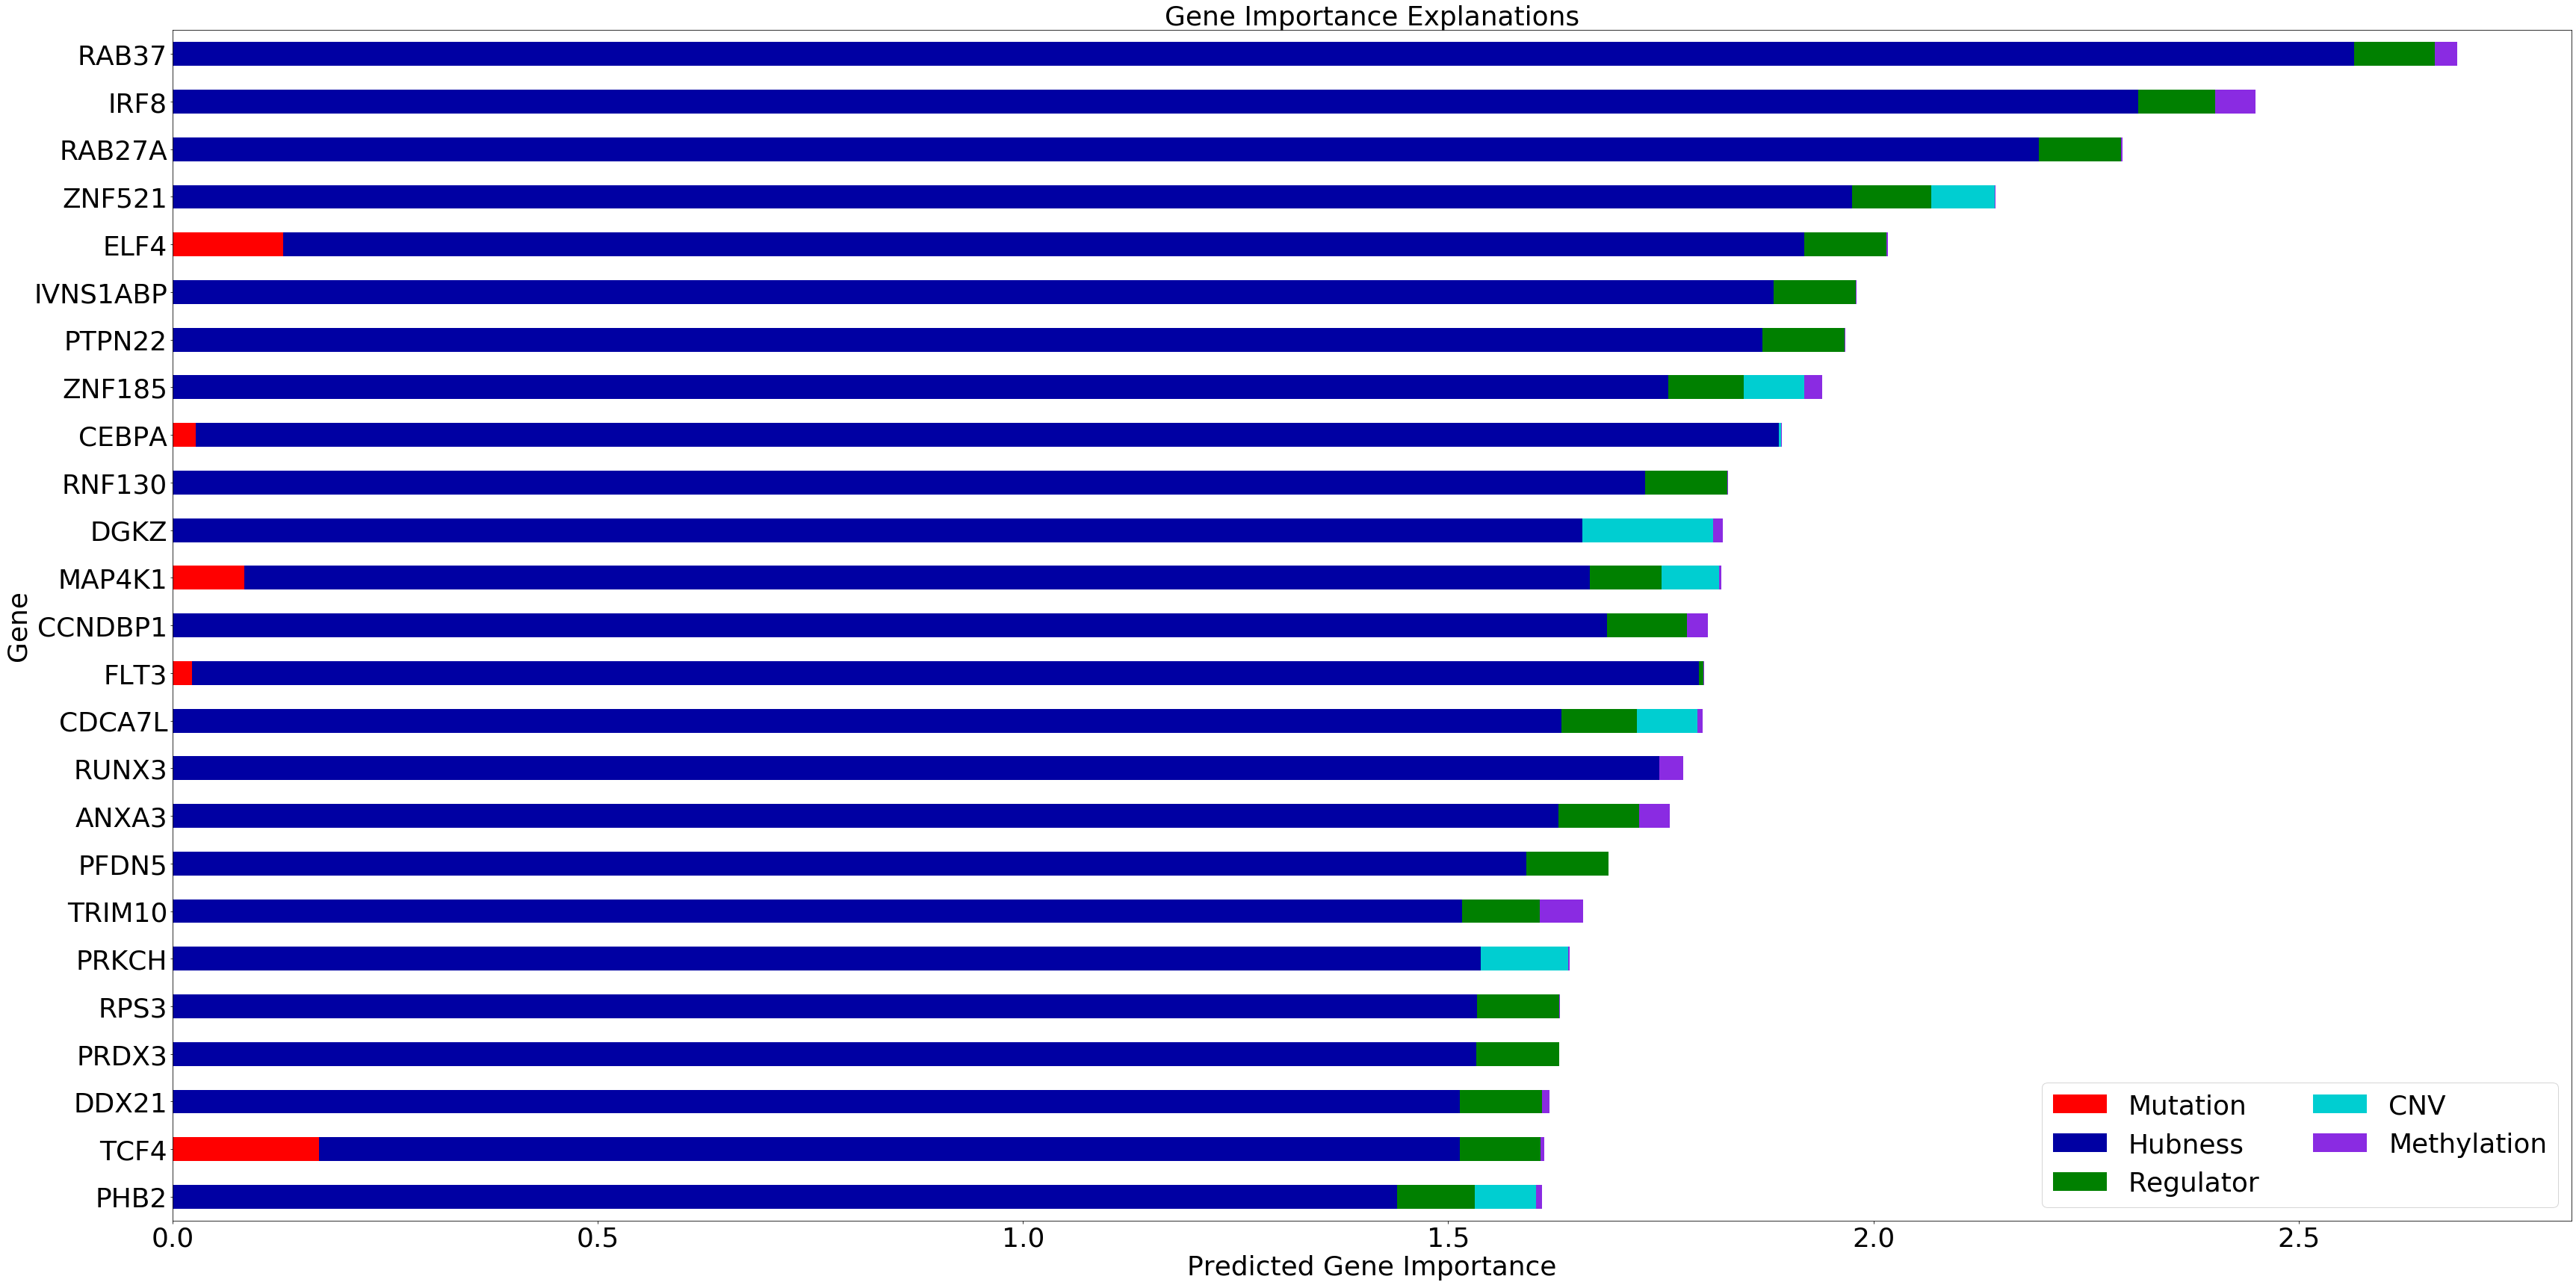

In [19]:
colors = {
    "mutation": "red",
    "hubness": "#0000A3",
    "regulator": "#008000",
    "cnv": "#00CED1",
    "methylation": "#8A2BE2"
}

mutation_bar = plt.Rectangle((0,0),1,1,fc=colors["mutation"], edgecolor = 'none')
hubness_bar = plt.Rectangle((0,0),1,1,fc=colors["hubness"],  edgecolor = 'none')
regulator_bar = plt.Rectangle((0,0),1,1,fc=colors["regulator"],  edgecolor = 'none')
cnv_bar = plt.Rectangle((0,0),1,1,fc=colors["cnv"], edgecolor = 'none')
methylation_bar = plt.Rectangle((0,0),1,1,fc=colors["methylation"],edgecolor = 'none')

data_to_plot.plot(
    kind="barh",
    stacked=True,
    color=[
        colors["mutation"],
        colors["hubness"],
        colors["regulator"],
        colors["cnv"],
        colors["methylation"]
    ],
    figsize=(48,24)
)

plt.xticks(fontsize=36)
plt.yticks(fontsize=36)

plt.legend(
    [mutation_bar, hubness_bar, regulator_bar, cnv_bar, methylation_bar],
    ['Mutation', 'Hubness', "Regulator", "CNV", "Methylation"],
    ncol = 2,
    prop={'size':36}
)

plt.title("Gene Importance Explanations", fontsize=36)
plt.ylabel("Gene", fontsize=36)
plt.xlabel("Predicted Gene Importance", fontsize=36)
plt.tight_layout()

In [20]:
"""
from sklearn import linear_model

potential_alphas = np.linspace(start=0, stop=1, num=100)[1:]
lasso_errors = []
for train_loader, test_loader, valid_loader in data_loaders:
    best_mse = float("inf")
    for alpha in potential_alphas:
        clf = linear_model.Lasso(alpha=alpha)
        clf.fit(train_loader.dataset.X, train_loader.dataset.y)
        predictions = clf.predict(test_loader.dataset.X)
        mse = ((predictions - test_loader.dataset.y.values)**2).mean()
        if mse < best_mse:
            best_mse = mse
    lasso_errors.append(best_mse)
"""

'\nfrom sklearn import linear_model\n\npotential_alphas = np.linspace(start=0, stop=1, num=100)[1:]\nlasso_errors = []\nfor train_loader, test_loader, valid_loader in data_loaders:\n    best_mse = float("inf")\n    for alpha in potential_alphas:\n        clf = linear_model.Lasso(alpha=alpha)\n        clf.fit(train_loader.dataset.X, train_loader.dataset.y)\n        predictions = clf.predict(test_loader.dataset.X)\n        mse = ((predictions - test_loader.dataset.y.values)**2).mean()\n        if mse < best_mse:\n            best_mse = mse\n    lasso_errors.append(best_mse)\n'

(0, 1.0898827055761209)

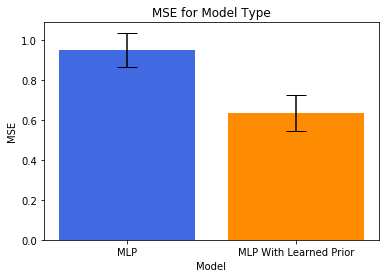

In [27]:
from scipy.stats import sem

test_errors_with_prior = np.array(test_errors_with_prior)
test_errors_no_prior = np.array(test_errors_no_prior)

mean_errors = [
    #lasso_errors.mean(),
    test_errors_no_prior.mean(),
    test_errors_with_prior.mean()
]

stderr = [
    sem(test_errors_no_prior),
    sem(test_errors_with_prior)
]

df = pd.DataFrame()

plt.bar(
    ["MLP", "MLP With Learned Prior"],
    mean_errors,
    yerr = stderr,
    align='center',
    ecolor='black',
    capsize=10,
    color=['royalblue', 'darkorange']
)
plt.title("MSE for Model Type")
plt.xlabel("Model")
plt.ylabel("MSE")
plt.ylim(0)

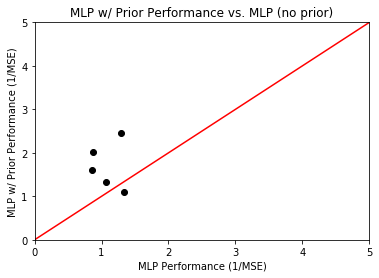

In [30]:
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

fig, ax = plt.subplots()
ax.scatter(x=1/test_errors_no_prior, y=1/test_errors_with_prior, c='black')
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
plt.xlim(0, 5.0)
plt.ylim(0, 5.0)
plt.xlabel("MLP Performance (1/MSE)")
plt.ylabel("MLP w/ Prior Performance (1/MSE)")
plt.title("MLP w/ Prior Performance vs. MLP (no prior)")
plt.show()

In [28]:
print(test_errors_with_prior)

[0.49298936 0.40798455 0.90818846 0.74999946 0.62430149]


In [29]:
print(test_errors_no_prior)

[1.13778484 0.77632231 0.75187051 0.93322062 1.1594286 ]
